# Topic modelling

In [35]:
import re
import string
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import scipy.sparse
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim import matutils, models

In [36]:
data = pd.read_csv("speeches_clean.csv", sep=",")
data.columns = ['Title', 'Date', 'Text']
data['Date']= pd.to_datetime(data['Date'])
data['Date'] = data['Date'].dt.date
data = data.dropna()
# Pre-processing
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('[\d\n]', ' ', text)
    return text
round1 = lambda x: clean_text(x).strip()
data_clean = data
data_clean['Text'] = data['Text'].apply(round1)
data_clean.head(3)

,Title,Date,Text
0,First President-Elect Press Conference,2008-11-07,irectly audio morning woke sobering news state...
1,Global Climate Summit Prerecorded Speech,2008-11-18,g world urgent climate change science beyond d...
2,Economic Team Announcement Speech,2008-11-24,ed text version directly audio news past week ...


In [37]:
all_words = data_clean['Text'].str.split(expand=True).unstack().value_counts()
data = [go.Bar(x = all_words.index.values[2:50],
                y = all_words.values[2:50],
                marker= dict(colorscale='Jet', color = all_words.values[2:100]),
                text='Word counts')]
layout = go.Layout(title='50 most common (uncleaned) word frequencies in dataset of speeches')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='basic-bar')

### Data engineering: term-document matrix

In [38]:
cv = CountVectorizer(stop_words = 'english')
data_cv = cv.fit_transform(data_clean['Text'])
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = data_clean[['Date','Title']].apply(lambda x: ': '.join(str(s) for s in x), axis=1)
data_dtm.head(10)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



,aa,abandon,abandoned,abatement,abbas,abdication,abduction,aberration,abet,abeyance,...,youthful,zag,zapatero,zeal,zero,zig,zimbabwe,zip,zone,¼history
2008-11-07: First President-Elect Press Conference,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2008-11-18: Global Climate Summit Prerecorded Speech,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2008-11-24: Economic Team Announcement Speech,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2008-11-26: Economic Recovery Advisory Board Announcement,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2008-12-01: Security Team Announcement Speech,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2008-12-03: Commerce Secretary Announcement,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2009-01-05: Remarks After Meeting with Economic Team,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2009-01-08: George Mason University Speech,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2009-01-09: Intelligence Community Leadership Team,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2009-01-18: Lincoln Memorial Pre-Inauguration Speech,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Transpose matrix to have words in rows instead of columns

In [39]:
data = data_dtm.transpose()
data.head()

,2008-11-07: First President-Elect Press Conference,2008-11-18: Global Climate Summit Prerecorded Speech,2008-11-24: Economic Team Announcement Speech,2008-11-26: Economic Recovery Advisory Board Announcement,2008-12-01: Security Team Announcement Speech,2008-12-03: Commerce Secretary Announcement,2009-01-05: Remarks After Meeting with Economic Team,2009-01-08: George Mason University Speech,2009-01-09: Intelligence Community Leadership Team,2009-01-18: Lincoln Memorial Pre-Inauguration Speech,...,2016-12-06: On the Administration's Approach to Counterterrorism,2016-12-16: Final Presidential Press Conference of Year,2016-12-27: Address at Pearl Harbor,2016-12-04: Farewell Address to the U.S. Armed Forces,2017-01-06: VOX Live Interview at the Blair House,2017-01-10: Presidential Farewell Address,2017-01-12: Joe Biden Medal of Freedom Presentation Address,2017-01-14: Final Presidential Weekly Address,2017-01-16: MLB World Series Champion Chicago Cubs WH Visit,2017-01-18: Final Presidential Press Conference
aa,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abandon,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
abandoned,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abatement,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abbas,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Calculating words frequency

In [40]:
top_dict = {}
for c in data.columns:
    top = data[c].sort_values(ascending=False).head(30)
    top_dict[c] = list(zip(top.index, top.values))

### Print out the TOP 15 words used in each speech

In [41]:
for title, top_words in top_dict.items():
    print(title)
    print(', '.join([word for word, count in top_words[0:14]]))
    print('---')

2008-11-07: First President-Elect Press Conference
financial, economy, crisis, auto, economic, team, going, work, government, immediate, help, president, transition, industry
---
2008-11-18: Global Climate Summit Prerecorded Speech
clean, change, governor, energy, climate, help, challenge, new, united, willing, invest, power, won, president
---
2008-11-24: Economic Team Announcement Speech
economic, crisis, policy, financial, work, administration, new, experience, working, street, economy, recovery, larry, know
---
2008-11-26: Economic Recovery Advisory Board Announcement
economic, board, advisory, new, recovery, announce, thinking, administration, president, serve, old, government, economy, plan
---
2008-12-01: Security Team Announcement Speech
security, world, national, need, people, power, face, new, secretary, military, commitment, time, attorney, century
---
2008-12-03: Commerce Secretary Announcement
work, world, economy, new, governor, time, commerce, business, key, won, know, s

### Identifying the top words that were used in multiple speeches.

In [42]:
# Look at the most common top words --> add them to the stop word list
# The top 10 most recurrent words in our speeches
words = []
for president in data.columns:
    top = [word for (word,count) in top_dict[president]]
    for t in top:
        words.append(t)
# List aggregation
Counter(words).most_common(10)

[('people', 321),
 ('make', 226),
 ('time', 223),
 ('know', 216),
 ('like', 202),
 ('work', 197),
 ('world', 190),
 ('want', 185),
 ('today', 182),
 ('going', 177)]

### Drop the most common words from the analysis

In [43]:
# If more than 1/5 the speeches have it as a top word, exclude it  from the list
add_stop_words = [word for word, count in Counter(words).most_common() if count > len(data.columns)/5]
add_stop_words.append('t')
add_stop_words.append('s')
add_stop_words.append('lot')
add_stop_words

['people',
 'make',
 'time',
 'know',
 'like',
 'work',
 'world',
 'want',
 'today',
 'going',
 'country',
 'new',
 'united',
 'right',
 'president',
 'way',
 'think',
 'got',
 'security',
 'said',
 'nation',
 'good',
 'need',
 'government',
 'thank',
 'sure',
 'say',
 'help',
 'come',
 't',
 's',
 'lot']

In [44]:
# Add new stop words
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)
# Recreate document-term matrix
cv = CountVectorizer(stop_words=stop_words)
data_cv = cv.fit_transform(data_clean.Text)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = data_clean[['Date','Title']].apply(lambda x: ': '.join(str(s) for s in x), axis=1)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



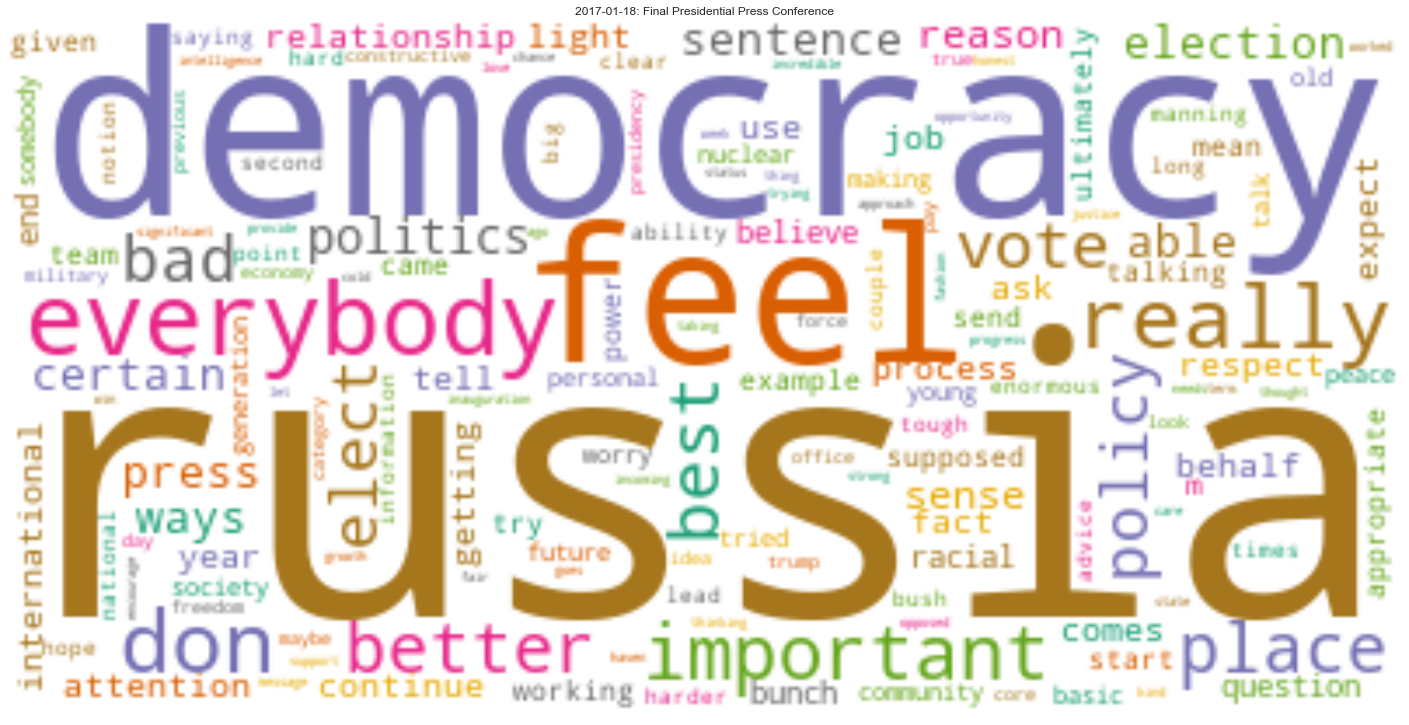

In [45]:
wc = WordCloud(stopwords=stop_words, background_color='white', colormap='Dark2', max_font_size=200, random_state=42)
data_clean.index = data_clean[['Date','Title']].apply(lambda x: ': '.join(str(s) for s in x), axis=1)
plt.rcParams['figure.figsize'] = [25, 15]
title_names = data.columns
# Create subplots for each speech
for index, speech in enumerate(data.columns):
    if index > 10:
        wc.generate(data_clean.Text[speech])
#plt.subplot(4, 3, 10)
plt.imshow( wc, interpolation='bilinear')
plt.axis("off")
plt.title(title_names[index])
plt.show()

In [46]:
 # Words counting
unique_list = []
for speech in data.columns:
    uniques = data[speech].to_numpy().nonzero()[0].size
    unique_list.append(uniques)
# Create a new dataframe that contains this unique word count
data_words = pd.DataFrame(list(zip(data.columns, unique_list)), columns=['speech', 'unique_words'])
data_unique_sort = data_words.sort_values(by='unique_words', ascending=False)
data_unique_sort

,speech,unique_words
157,2012-10-23: Third Debate with Mitt Romney,1226
156,2012-10-17: Second Debate with Mitt Romney,1225
322,2016-04-07: Conversation at the University. of...,1178
155,2012-10-03: First Debate with Mitt Romney,1146
358,2016-12-16: Final Presidential Press Conferenc...,1130
...,...,...
162,2012-12-14: On the Sandy Hook Elementary Schoo...,93
351,2016-11-10: First Meeting with President-Elect...,83
288,2015-11-13: Message to the People of Burundi,81
167,2013-01-21: Inaugural Luncheon Toast,79


Model generation : Topic Modeling

In [47]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ignacyklimont/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ignacyklimont/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

‘NN’ four nouns;
‘JJ’ for adjectives;
‘CC’ for coordinating conjunctions;
‘RB’ for adverbs;
‘IN’ for prepositions;

In [48]:
from nltk.tokenize import word_tokenize
from nltk import pos_tag
def nouns_adjs(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'
    tokenized = word_tokenize(text)
    all_nouns_adjs = [word for (word, pos) in pos_tag(tokenized) if is_noun_adj(pos)]
    return ' '.join(all_nouns_adjs)
# Apply the nouns function to the transcripts to filter only on nouns and adjectives
data_nouns_adjs = pd.DataFrame(data_clean.Text.apply(nouns_adjs))
data_nouns_adjs.head()

,Text
2008-11-07: First President-Elect Press Conference,audio morning news state economy consecutive m...
2008-11-18: Global Climate Summit Prerecorded Speech,g world urgent climate change science dispute ...
2008-11-24: Economic Team Announcement Speech,ed text version audio news week morning  s ne...
2008-11-26: Economic Recovery Advisory Board Announcement,crisis historic moment nation history old ways...
2008-12-01: Security Team Announcement Speech,morning everybody last week speak craft econom...


### Reconstruct our document-term matrix :

In [49]:
# Re-add the additional stop words since we are recreating the document-term matrix
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)
# Recreate a document-term matrix with nouns and adjectives
cvna = CountVectorizer(stop_words=stop_words)
data_cvna = cvna.fit_transform(data_nouns_adjs.Text)
data_dtmna = pd.DataFrame(data_cvna.toarray(), columns=cvna.get_feature_names())
data_dtmna.index = data_nouns_adjs.index
data_dtmna.head(10)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



,aa,abandon,abatement,abbas,abdication,abduction,aberration,abet,abeyance,abhor,...,youthful,zag,zapatero,zeal,zero,zig,zimbabwe,zip,zone,¼history
2008-11-07: First President-Elect Press Conference,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2008-11-18: Global Climate Summit Prerecorded Speech,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2008-11-24: Economic Team Announcement Speech,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2008-11-26: Economic Recovery Advisory Board Announcement,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2008-12-01: Security Team Announcement Speech,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2008-12-03: Commerce Secretary Announcement,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2009-01-05: Remarks After Meeting with Economic Team,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2009-01-08: George Mason University Speech,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2009-01-09: Intelligence Community Leadership Team,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2009-01-18: Lincoln Memorial Pre-Inauguration Speech,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
# Create the gensim corpus
corpusna = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmna.transpose()))
# Create the vocabulary dictionary
id2wordna = dict((v, k) for k, v in cvna.vocabulary_.items())
corpusna

In [51]:
ldana = models.LdaModel(corpus=corpusna, num_topics =5 , id2word=id2wordna, passes=20)
ldana.save('mode1.gensim')
ldana.print_topics()

[(0,
  '0.009*"nuclear" + 0.007*"war" + 0.007*"international" + 0.006*"peace" + 0.006*"military" + 0.006*"future" + 0.005*"region" + 0.005*"support" + 0.005*"human" + 0.005*"young"'),
 (1,
  '0.013*"health" + 0.012*"care" + 0.009*"economy" + 0.009*"insurance" + 0.008*"year" + 0.007*"congress" + 0.006*"everybody" + 0.006*"thing" + 0.006*"don" + 0.006*"able"'),
 (2,
  '0.015*"governor" + 0.010*"war" + 0.010*"energy" + 0.010*"oil" + 0.008*"military" + 0.008*"home" + 0.008*"day" + 0.007*"year" + 0.006*"service" + 0.006*"future"'),
 (3,
  '0.021*"font" + 0.021*"line" + 0.020*"style" + 0.015*"family" + 0.011*"size" + 0.010*"span" + 0.009*"align" + 0.007*"court" + 0.007*"justice" + 0.006*"faith"'),
 (4,
  '0.010*"life" + 0.008*"young" + 0.008*"men" + 0.008*"day" + 0.006*"great" + 0.006*"family" + 0.006*"man" + 0.005*"change" + 0.005*"community" + 0.004*"story"')]

In [52]:
# Compute Perplexity
print('\nPerplexity: ', ldana.log_perplexity(corpusna))  # a measure of how good the model is. lower the better.


Perplexity:  -7.529087287533224


We can interpret the 5 topics as follows :
1. Topic 1 : Economy
2. Topic 2 : Patriotism
3. Topic 3 : Gun control
4. Topic 4 : Affordable care act
5. Topic 5 : Nobel Peace Prize

Identify which topics are discussed in each document

In [53]:
# Let's take a look at which topics each speech contains
corpus_transformed = ldana[corpusna]
# 1: Sorting topics for each speech
sorted_corpus_transformed = [sorted(a, key=lambda x: x[1], reverse=True) for a in corpus_transformed]
[a for a in enumerate(corpus_transformed)]
# 2: Matching topics to speeches
topics = list(zip(data_dtmna.index,
                  [c[0][0] for c in sorted_corpus_transformed],
                  [c[1][0] if len(c)>1 else -1 for c in sorted_corpus_transformed],
                  [c[2][0] if len(c)>2 else -1 for c in sorted_corpus_transformed],
                  [c[3][0] if len(c)>3 else -1 for c in sorted_corpus_transformed],
                  [c[4][0] if len(c)>4 else -1 for c in sorted_corpus_transformed]
                  ))
# 3: Saving the result in a DataFrame
df = pd.DataFrame(topics, columns = ['speech', 'topic 1', 'topic 2', 'topic 3','topic 4', 'topic 5'])
df.head(20)

,speech,topic 1,topic 2,topic 3,topic 4,topic 5
0,2008-11-07: First President-Elect Press Confer...,1,0,-1,-1,-1
1,2008-11-18: Global Climate Summit Prerecorded ...,2,0,1,-1,-1
2,2008-11-24: Economic Team Announcement Speech,1,0,-1,-1,-1
3,2008-11-26: Economic Recovery Advisory Board A...,1,3,0,-1,-1
4,2008-12-01: Security Team Announcement Speech,0,2,-1,-1,-1
5,2008-12-03: Commerce Secretary Announcement,2,1,0,-1,-1
6,2009-01-05: Remarks After Meeting with Economi...,1,-1,-1,-1,-1
7,2009-01-08: George Mason University Speech,1,2,-1,-1,-1
8,2009-01-09: Intelligence Community Leadership ...,0,1,2,3,-1
9,2009-01-18: Lincoln Memorial Pre-Inauguration ...,4,2,-1,-1,-1


Dataframe with the weights

In [54]:
# Including probabilities
w_topic1 = [c[0][1] if c[0][0] == 0 else c[1][1] if (len(c)>1 and c[1][0] == 0) else c[2][1] if ( len(c)>2 and c[2][0] == 0) else 0 for c in sorted_corpus_transformed]
w_topic2 = [c[0][1] if c[0][0] == 1 else c[1][1] if (len(c)>1 and c[1][0] == 1) else c[2][1] if (len(c)>2 and c[2][0] == 1) else 0 for c in sorted_corpus_transformed]
w_topic3 = [c[0][1] if c[0][0] == 2 else c[1][1] if (len(c)>1 and c[1][0] == 2) else c[2][1] if (len(c)>2 and c[2][0] == 2) else 0 for c in sorted_corpus_transformed]
w_topic4 = [c[0][1] if c[0][0] == 3 else c[1][1] if (len(c)>1 and c[1][0] == 3) else c[2][1] if (len(c)>2 and c[2][0] == 3) else 0 for c in sorted_corpus_transformed]
w_topic5 = [c[0][1] if c[0][0] == 4 else c[1][1] if (len(c)>1 and c[1][0] == 4) else c[2][1] if (len(c)>2 and c[2][0] == 4) else 0 for c in sorted_corpus_transformed]
p_topics = list(zip(data_dtmna.index, w_topic1, w_topic2, w_topic3, w_topic4, w_topic5))
p_df = pd.DataFrame(p_topics, columns = ['speech', 'topic1', 'topic2', 'topic3','topic4', 'topic5'])
p_df.head(20)

,speech,topic1,topic2,topic3,topic4,topic5
0,2008-11-07: First President-Elect Press Confer...,0.034427,0.962894,0.000000,0.000000,0.000000
1,2008-11-18: Global Climate Summit Prerecorded ...,0.457798,0.036592,0.503071,0.000000,0.000000
2,2008-11-24: Economic Team Announcement Speech,0.138372,0.860331,0.000000,0.000000,0.000000
3,2008-11-26: Economic Recovery Advisory Board A...,0.093566,0.621025,0.000000,0.283508,0.000000
4,2008-12-01: Security Team Announcement Speech,0.943164,0.000000,0.055405,0.000000,0.000000
5,2008-12-03: Commerce Secretary Announcement,0.308638,0.343076,0.345816,0.000000,0.000000
6,2009-01-05: Remarks After Meeting with Economi...,0.000000,0.997414,0.000000,0.000000,0.000000
7,2009-01-08: George Mason University Speech,0.000000,0.956013,0.042997,0.000000,0.000000
8,2009-01-09: Intelligence Community Leadership ...,0.779916,0.111327,0.089521,0.000000,0.000000
9,2009-01-18: Lincoln Memorial Pre-Inauguration ...,0.000000,0.000000,0.350315,0.000000,0.645128


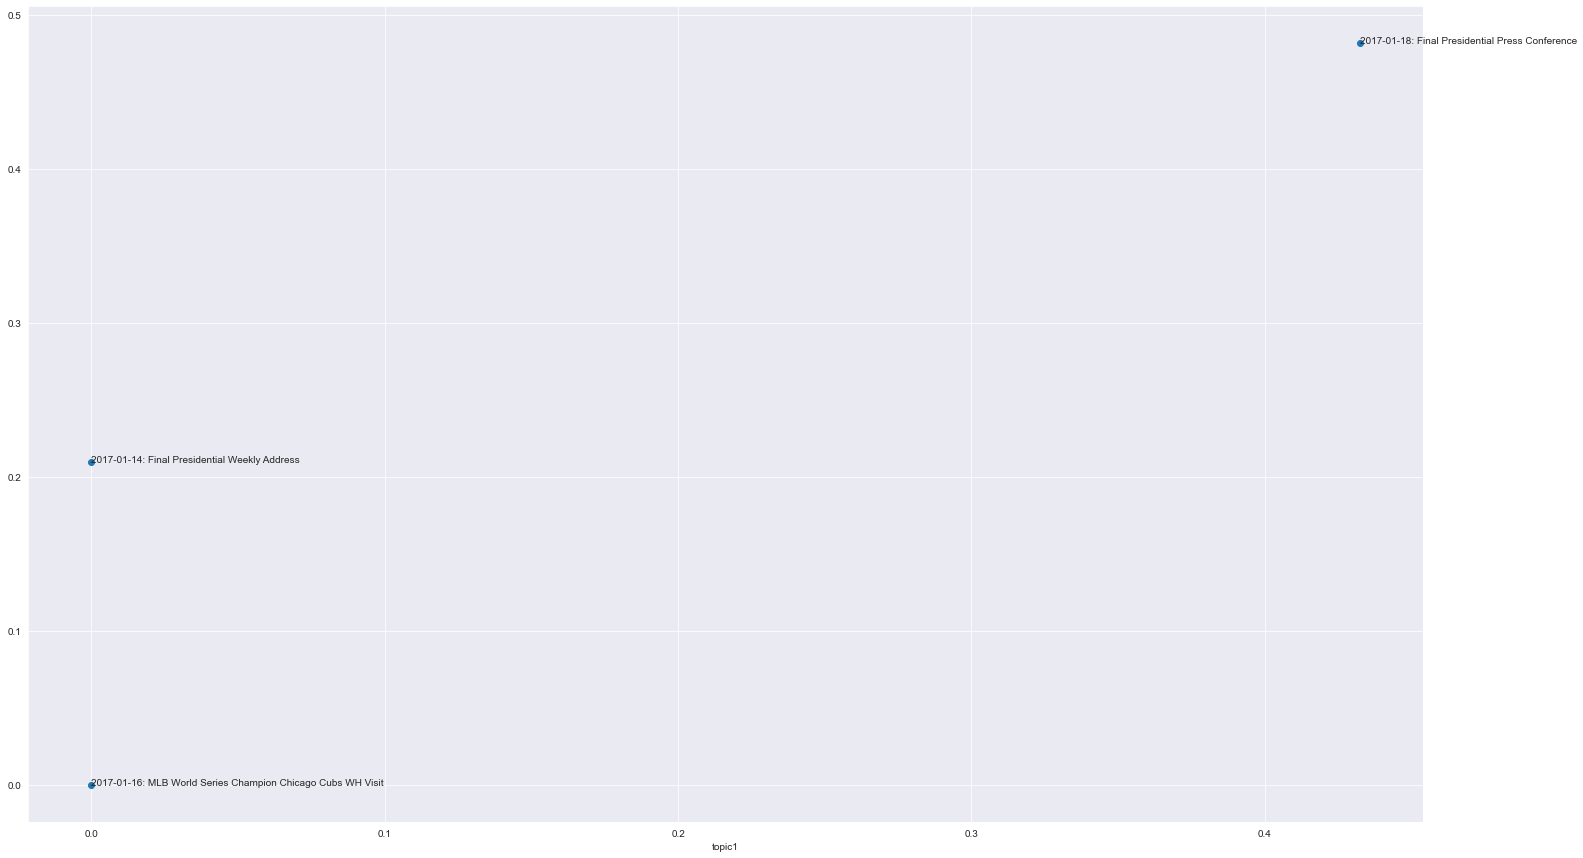

In [55]:
from matplotlib.pyplot import draw
# We visualize the last three inaugural speeches
p_df12 = p_df[-3:]
ax12 = p_df12.set_index('topic1')['topic2'].plot(style='o')
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], str(point['val']))
label_point(p_df12['topic1'], p_df12['topic2'], p_df12['speech'], ax12)
draw()

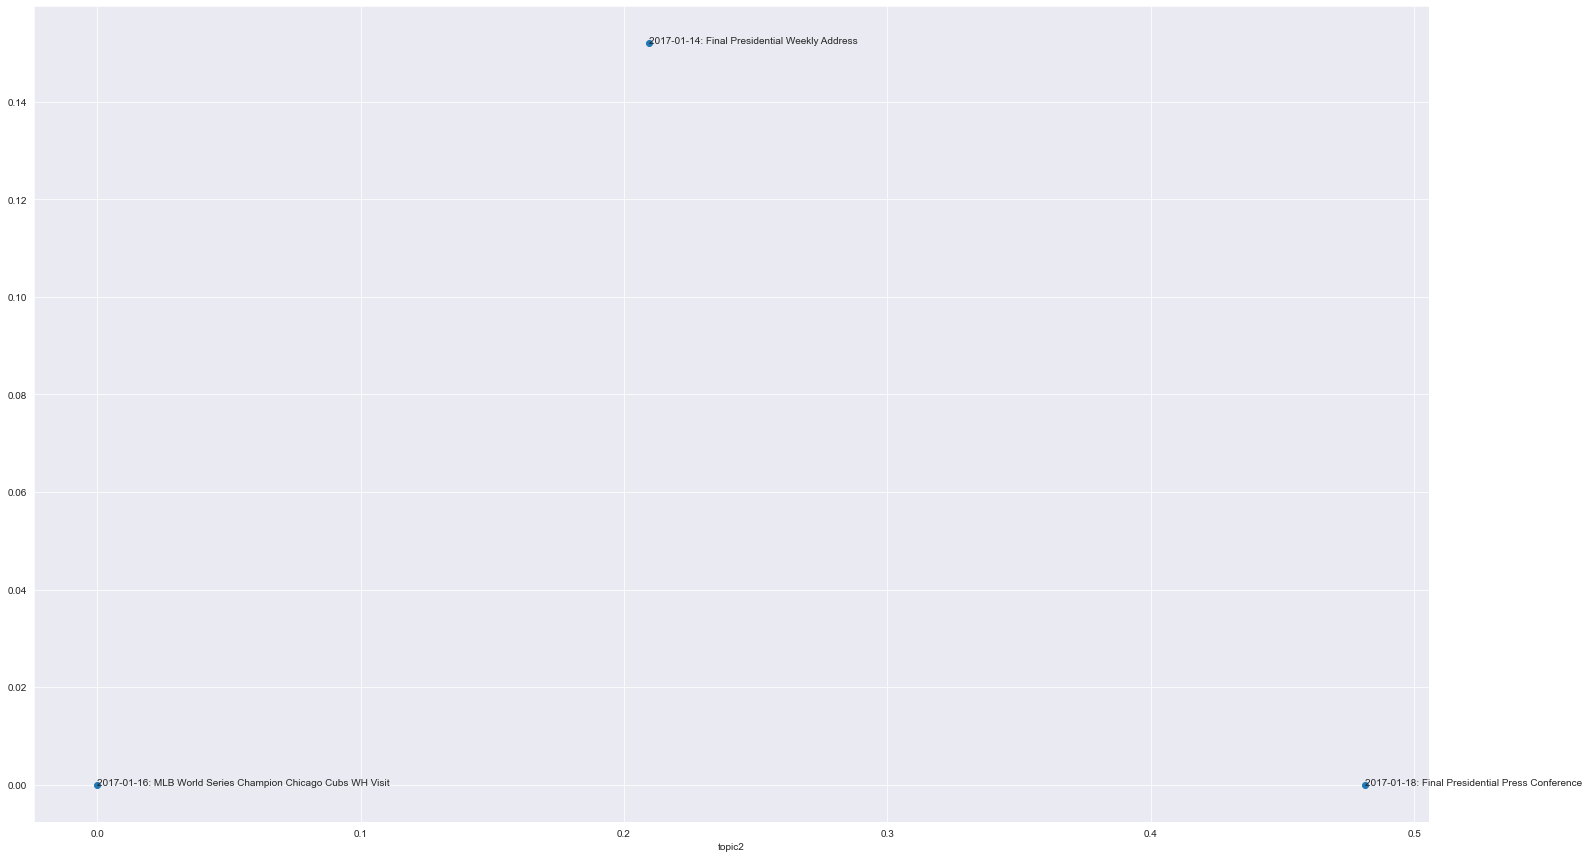

In [56]:
p_df23 = p_df[-3:]
ax23 = p_df23.set_index('topic2')['topic3'].plot(style='o')
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], str(point['val']))
label_point(p_df23['topic2'], p_df23['topic3'], p_df23['speech'], ax23)
draw()

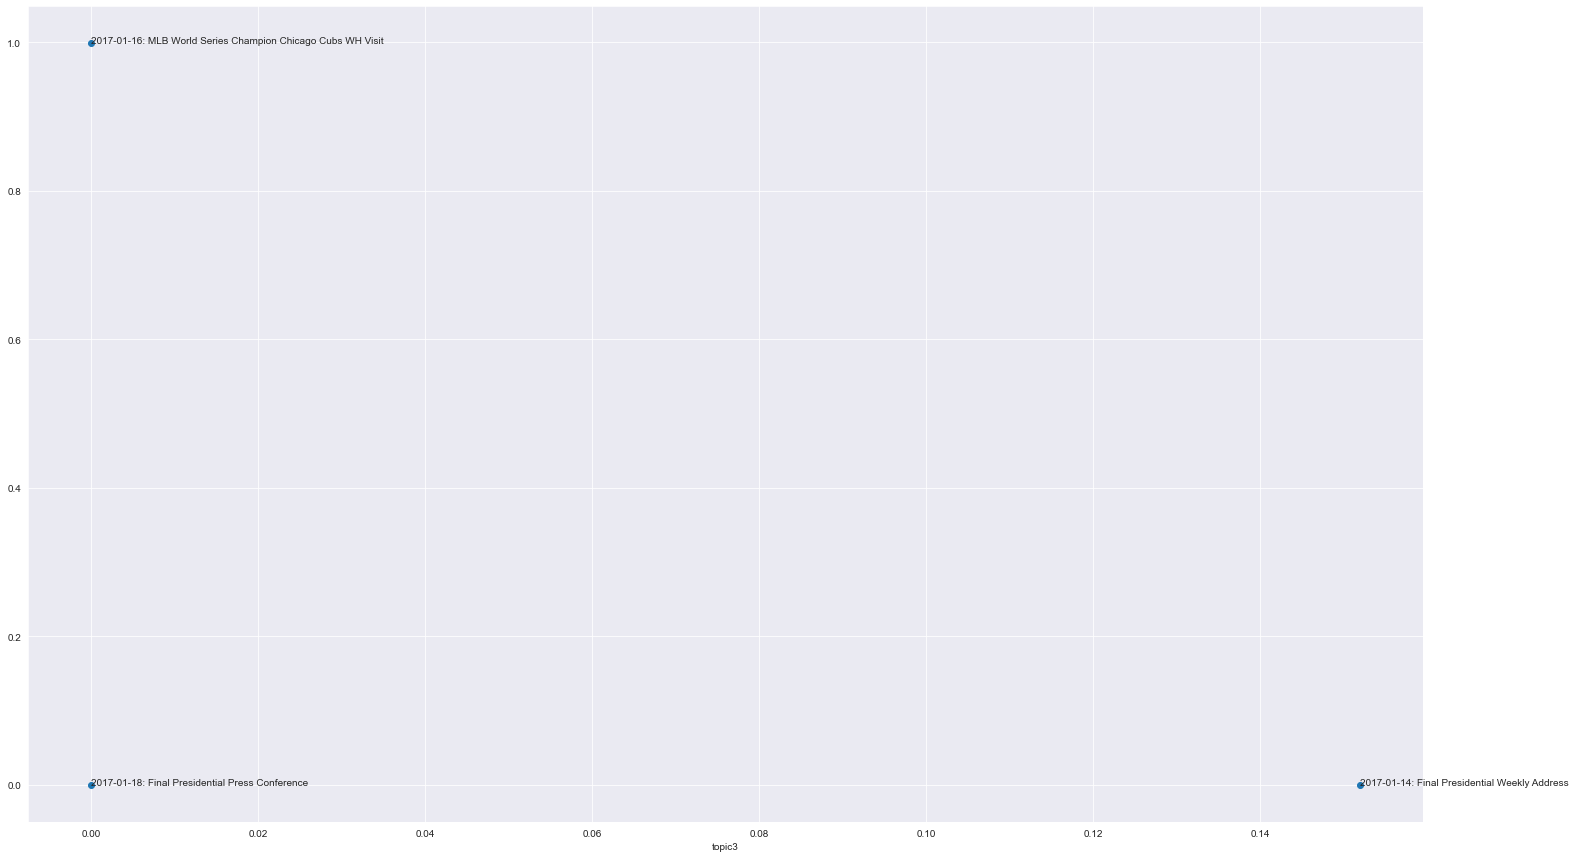

In [57]:
p_df23 = p_df[-3:]
ax23 = p_df23.set_index('topic3')['topic4'].plot(style='o')
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], str(point['val']))
label_point(p_df23['topic3'], p_df23['topic4'], p_df23['speech'], ax23)
draw()

In [58]:
from textblob import TextBlob
# function to calculate subjectivity
def getSubjectivity(content):
    return TextBlob(content).sentiment.subjectivity
    # function to calculate polarity
def getPolarity(content):
    return TextBlob(content).sentiment.polarity

# function to analyze the reviews
def analysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

In [59]:
fin_data = pd.DataFrame(data_nouns_adjs[['Text']])
fin_data['Subjectivity'] = fin_data['Text'].apply(getSubjectivity)
fin_data['Polarity'] = fin_data['Text'].apply(getPolarity)
fin_data['Analysis'] = fin_data['Polarity'].apply(analysis)
fin_data.head(10)

,Text,Subjectivity,Polarity,Analysis
2008-11-07: First President-Elect Press Conference,audio morning news state economy consecutive m...,0.367381,0.105164,Positive
2008-11-18: Global Climate Summit Prerecorded Speech,g world urgent climate change science dispute ...,0.465218,0.192631,Positive
2008-11-24: Economic Team Announcement Speech,ed text version audio news week morning  s ne...,0.328523,0.159434,Positive
2008-11-26: Economic Recovery Advisory Board Announcement,crisis historic moment nation history old ways...,0.342143,0.160240,Positive
2008-12-01: Security Team Announcement Speech,morning everybody last week speak craft econom...,0.405455,0.124952,Positive
2008-12-03: Commerce Secretary Announcement,e key member team secretary commerce great fri...,0.394899,0.113799,Positive
2009-01-05: Remarks After Meeting with Economic Team,c team message meeting today difficult spot ec...,0.430912,0.087505,Positive
2009-01-08: George Mason University Speech,ied text version audio let mason university ex...,0.463426,0.117453,Positive
2009-01-09: Intelligence Community Leadership Team,thenticity text version audio discuss today  ...,0.474150,0.188694,Positive
2009-01-18: Lincoln Memorial Pre-Inauguration Speech,ant thank today want thank cold join today wel...,0.578900,0.108889,Positive


In [60]:
tb_counts = fin_data.Analysis.value_counts()

tb_counts

Positive    365
Negative      2
Name: Analysis, dtype: int64

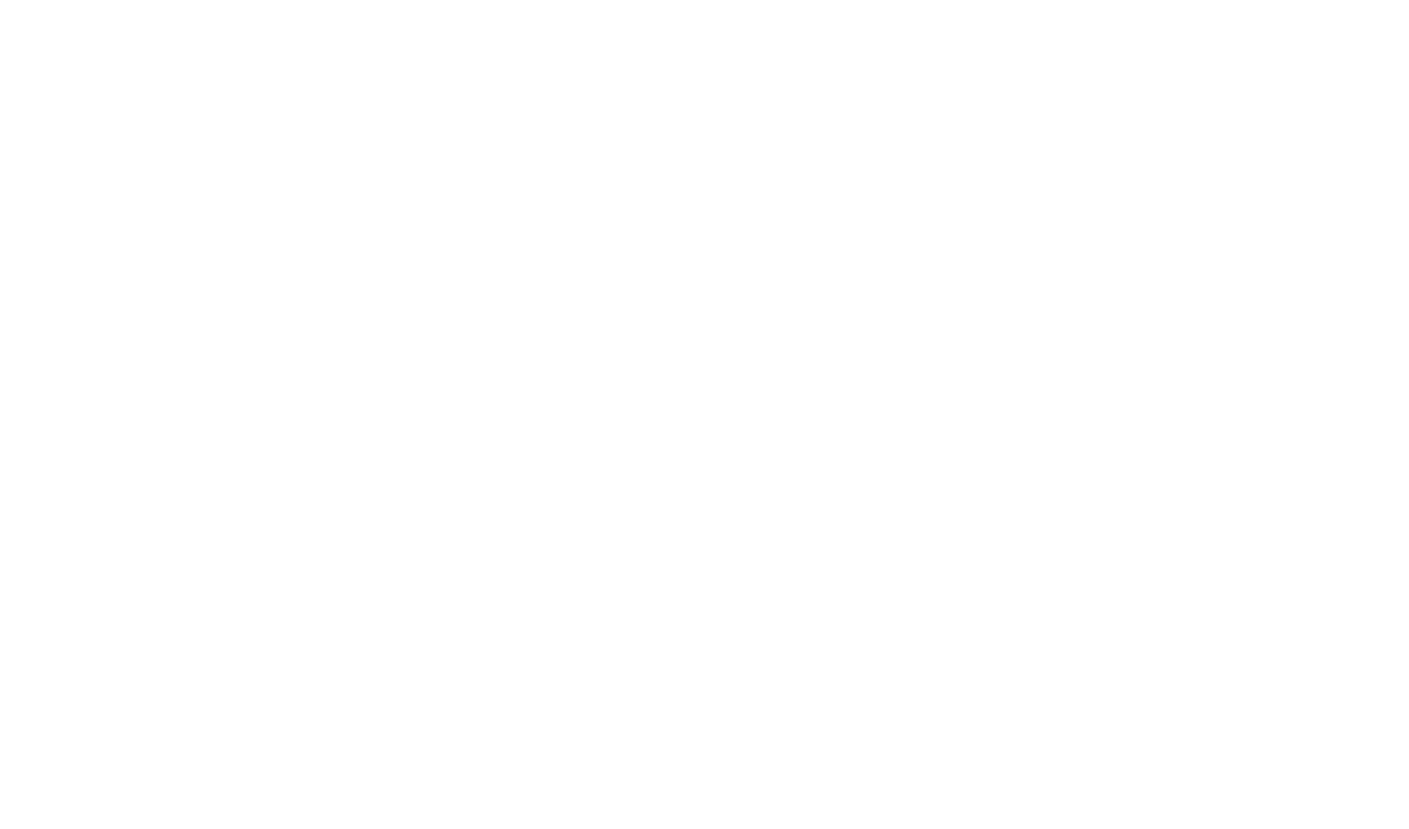

In [61]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_fn(fin_data,measure):
    fig = plt.figure(figsize=(30, 2))

    # draw lines
    xmin = -1
    xmax = 1
    y = 5
    height = 2

    plt.hlines(y, xmin, xmax)
    plt.vlines(xmin, y - height / 2., y + height / 2.)
    plt.vlines(xmax, y - height / 2., y + height / 2.)

    # draw a point on the line
    px1 = fin_data[measure]['2009-01-20: FIRST PRESIDENTIAL INAUGURAL ADDRESS']
    plt.plot(px1,y, 'bo', ms = 30, mfc = 'b')

    plt.title(measure, loc='center', pad=50,fontsize=50)
    plt.text(px1,y+1,round(px1,2),horizontalalignment='center',verticalalignment='center',fontsize=25)
   

    # add numbers
    if(measure=='Polarity'):
        plt.text(xmin - 0.01, y, 'Negative(-1)', horizontalalignment='right',verticalalignment='center',fontsize=30)
       
        plt.text(px1,y-1.5,'2009-01-20: FIRST PRESIDENTIAL INAUGURAL ADDRESS',horizontalalignment='left',verticalalignment='center',fontsize=25)
        plt.text(xmax + 0.01, y, 'Positive(+1)', horizontalalignment='left',verticalalignment='center',fontsize=30)
       
    else:
        plt.text(xmin - 0.01, y, 'Objective(0)', horizontalalignment='right',verticalalignment='center',fontsize=30)
        plt.text(xmin-0.1 , y-1.5, 'Fact', horizontalalignment='left',verticalalignment='center',fontsize=30)

        plt.text(px1,y-1.5,'2009-01-20: FIRST PRESIDENTIAL INAUGURAL ADDRESS',horizontalalignment='right',verticalalignment='center',fontsize=25)
        plt.text(xmax + 0.01, y, 'Subjective(1)', horizontalalignment='left',verticalalignment='center',fontsize=30)
        plt.text(xmax + 0.04, y-1.5, 'Opinion', horizontalalignment='left',verticalalignment='center',fontsize=30)
       

plt.axis('off')
plt.show()

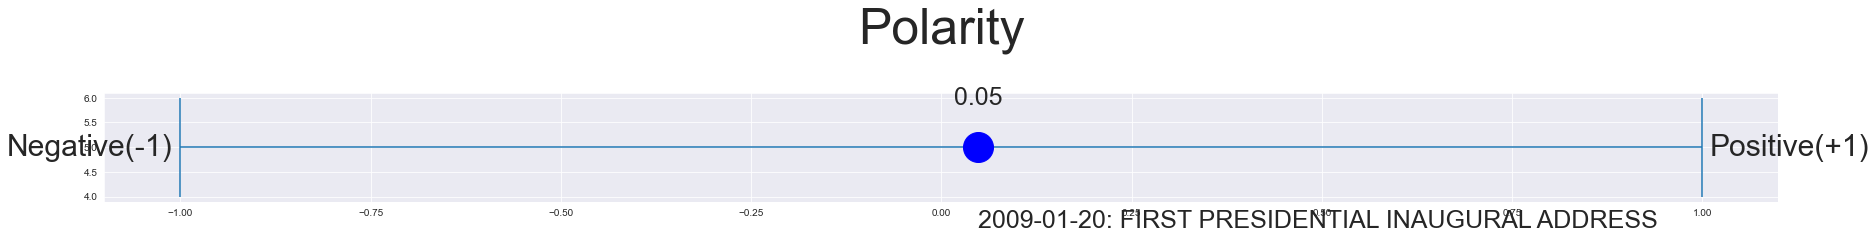

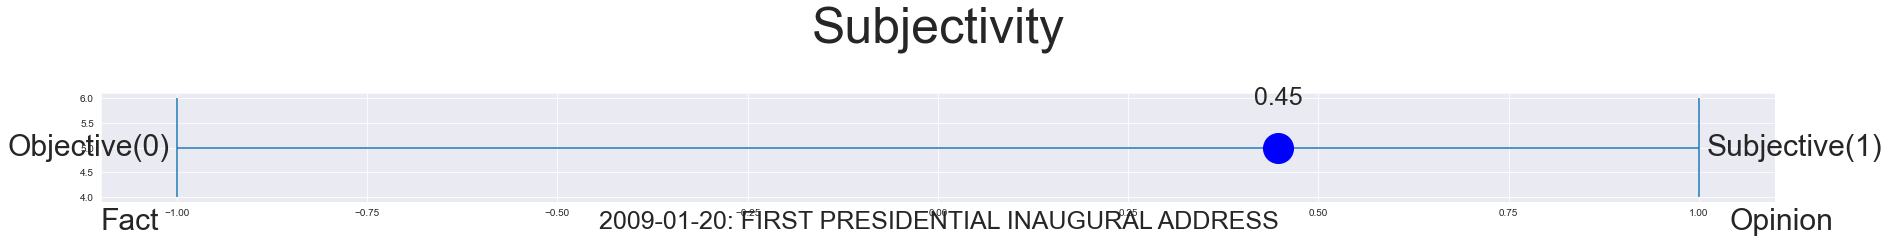

In [62]:
plot_fn(fin_data,'Polarity')
plot_fn(fin_data,'Subjectivity')